<a href="https://colab.research.google.com/github/SushmaKewat/TinyVGG-with-PyTorch/blob/main/CV_Model_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Computer Vision with Pytorch

Dataset from Food101 dataset

We'll have 4 classes:
1. Sushi
2. Cup cakes
3. Macarons
4. Chocolate cake

## Setup Library

In [2]:
import torch
from torch import nn

#Pytorch 1.10.0+ is required
torch.__version__

'2.6.0+cu124'

In [3]:
# Check if connected to a GPU
torch.cuda.is_available()

False

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get Data

In [5]:
import requests # make requests over http
import zipfile
from pathlib import Path
import os

#Setup data path
data_path = Path("data/")
image_path = data_path / "food_images"

# if the image folder doesn't exist , download it preapre it...
if image_path.is_dir():
  print(f"{image_path} directory already exists, skipping download.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download the data zip file
with open(data_path / "food_images.zip", "wb") as f: # wb: write binary
  request = requests.get("https://programmingoceanacademy.s3.ap-southeast-1.amazonaws.com/image_classification_dataset.zip")
  print("Downloading the food images data....")
  f.write(request.content)

# Unzip data file .zip
with zipfile.ZipFile(data_path / "food_images.zip", "r") as zip_ref: # r: read mode
  print("Unzipping the food images data....")
  zip_ref.extractall(image_path)

Did not find data/food_images directory, creating one...
Unzipping the food images data....


In [6]:
os.remove("/content/data/food_images.zip")

In [7]:
train_dir = image_path / "dataset/train"
test_dir = image_path / "dataset/test"

## Data exploration and Preparation

In [8]:
def walkthrough_dir(dir_path):
  """"Walks through dir_path and returns it's contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} in '{dirpath}")

In [9]:
walkthrough_dir(image_path)

There are 1 directories and 0 in 'data/food_images
There are 2 directories and 0 in 'data/food_images/dataset
There are 4 directories and 0 in 'data/food_images/dataset/train
There are 0 directories and 250 in 'data/food_images/dataset/train/macarons
There are 0 directories and 250 in 'data/food_images/dataset/train/cup_cakes
There are 0 directories and 250 in 'data/food_images/dataset/train/sushi
There are 0 directories and 250 in 'data/food_images/dataset/train/chocolate_cake
There are 4 directories and 0 in 'data/food_images/dataset/test
There are 0 directories and 75 in 'data/food_images/dataset/test/macarons
There are 0 directories and 75 in 'data/food_images/dataset/test/cup_cakes
There are 0 directories and 75 in 'data/food_images/dataset/test/sushi
There are 0 directories and 75 in 'data/food_images/dataset/test/chocolate_cake


Image path: data/food_images/dataset/test/cup_cakes/1466557.jpg
Image class: cup_cakes
Image height: 512
Image width: 512


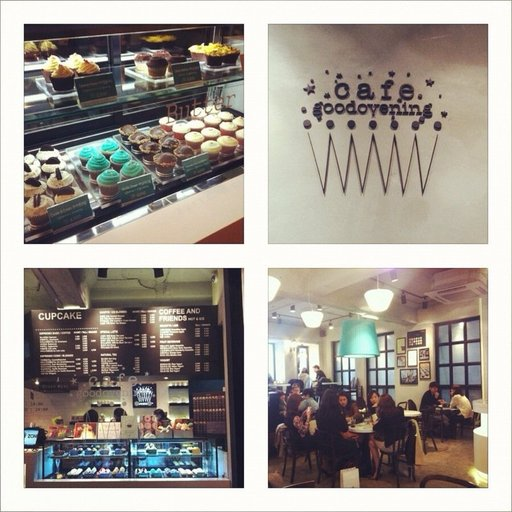

In [10]:
import random
from PIL import Image # PIL: Python Image Library

# Get all image paths
image_path_list = list(image_path.glob("*/*/*/*.jpg"))

# image_path_list
# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Display the image
img = Image.open(random_image_path)

# Print image path and class
print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

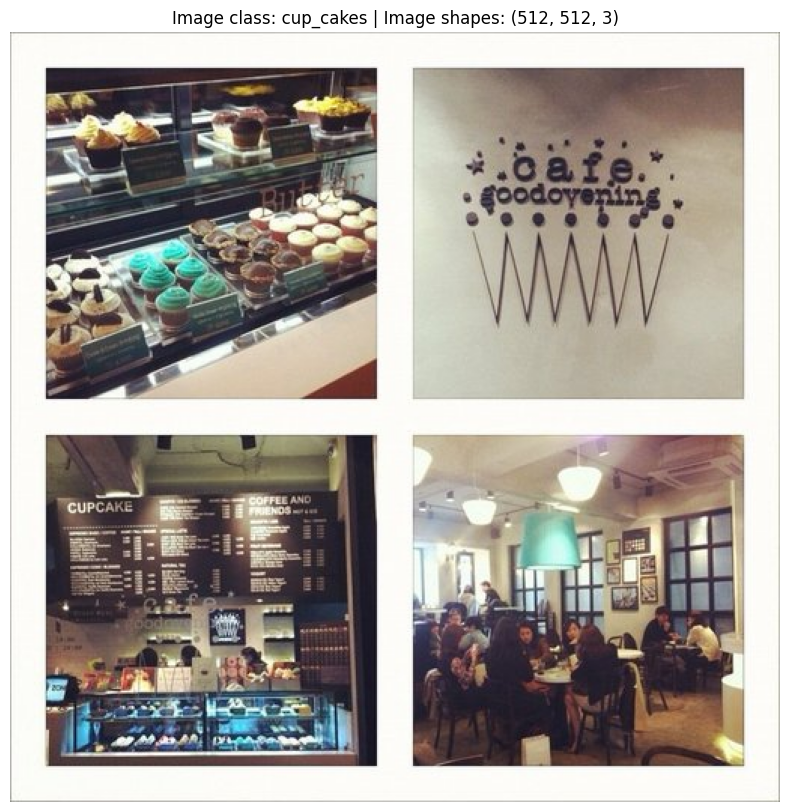

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into array
img_as_array = np.asarray(img)

plt.figure(figsize=(10,10))
plt.imshow(img_as_array)
plt.axis("off")
plt.title(f"Image class: {image_class} | Image shapes: {img_as_array.shape}")
plt.show()

array([[[150, 149, 144],
        [192, 191, 186],
        [173, 172, 167],
        ...,
        [180, 180, 172],
        [197, 197, 187],
        [151, 151, 141]],

       [[199, 198, 193],
        [253, 252, 247],
        [245, 244, 239],
        ...,
        [248, 248, 240],
        [255, 255, 245],
        [197, 197, 187]],

       [[186, 185, 180],
        [250, 249, 244],
        [247, 246, 241],
        ...,
        [247, 247, 239],
        [248, 248, 240],
        [180, 180, 172]],

       ...,

       [[165, 166, 160],
        [247, 248, 242],
        [252, 253, 247],
        ...,
        [252, 252, 244],
        [253, 253, 243],
        [176, 176, 166]],

       [[189, 190, 184],
        [249, 250, 244],
        [250, 251, 245],
        ...,
        [247, 247, 237],
        [254, 254, 244],
        [187, 187, 177]],

       [[142, 143, 137],
        [179, 180, 174],
        [173, 174, 168],
        ...,
        [184, 184, 174],
        [201, 201, 191],
        [149, 149, 139]]], dtype=uint8)
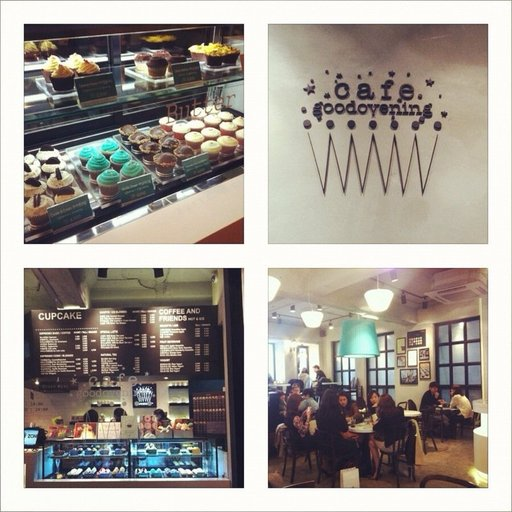

In [12]:
img_as_array

## Transforming Data

1. Turn the target data into tensors
2. Turn into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`.

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [14]:
# Transforming data with `torchvision.tranforms`
data_transform = transforms.Compose( #combines different transformations into a single pipeline
    [
        # Resize images to 64X64
        transforms.Resize(size=(64, 64)),

        # Flip the images randomly on the horizontal axis
        transforms.RandomHorizontalFlip(p=0.5), # Flip the images 50% of the time

        #Random Perspective
        # transforms.RandomPerspective()

        #Random Rotation
        # transforms.RandomRotation(degrees=0.2),

        # Convert the images to a PyTorch tensor
        transforms.ToTensor(),
    ]
)

In [15]:
data_transform(img).shape

torch.Size([3, 64, 64])

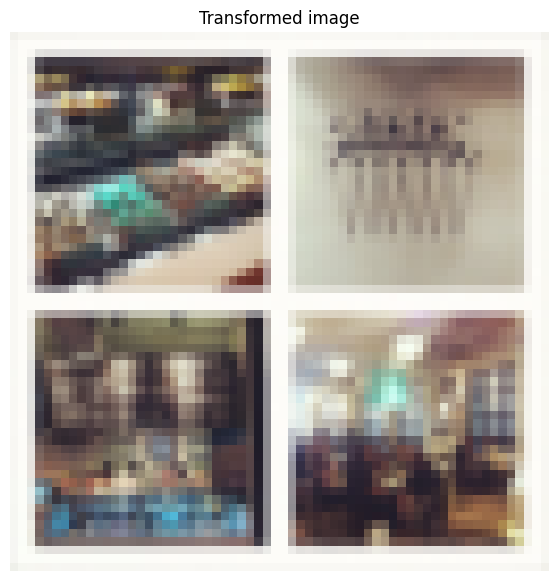

In [16]:
plt.figure(figsize=(10, 7))
plt.imshow(data_transform(img).permute(1, 2, 0))
plt.axis("off")
plt.title("Transformed image")
plt.show()

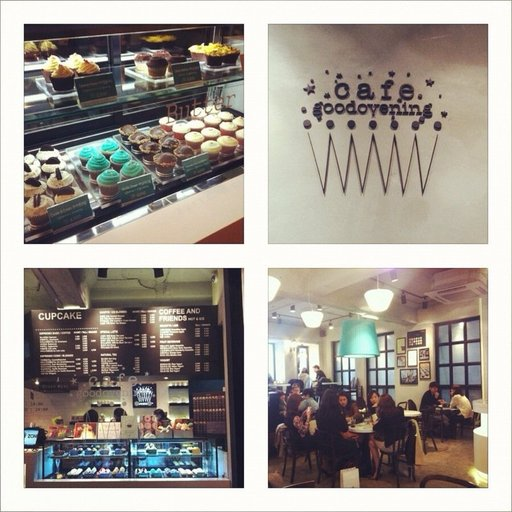

In [17]:
img

In [18]:
data_transform(img)

tensor([[[0.9490, 0.9725, 0.9725,  ..., 0.9686, 0.9686, 0.9490],
         [0.9725, 0.9922, 0.9922,  ..., 0.9922, 0.9922, 0.9725],
         [0.9725, 0.9922, 0.9804,  ..., 0.9765, 0.9922, 0.9725],
         ...,
         [0.9725, 0.9922, 0.9843,  ..., 0.9765, 0.9882, 0.9647],
         [0.9686, 0.9922, 0.9922,  ..., 0.9882, 0.9882, 0.9647],
         [0.9490, 0.9725, 0.9725,  ..., 0.9686, 0.9647, 0.9373]],

        [[0.9451, 0.9686, 0.9686,  ..., 0.9647, 0.9647, 0.9451],
         [0.9686, 0.9882, 0.9882,  ..., 0.9882, 0.9882, 0.9686],
         [0.9725, 0.9882, 0.9725,  ..., 0.9725, 0.9882, 0.9725],
         ...,
         [0.9686, 0.9882, 0.9804,  ..., 0.9804, 0.9961, 0.9647],
         [0.9686, 0.9882, 0.9882,  ..., 0.9922, 0.9922, 0.9647],
         [0.9451, 0.9686, 0.9686,  ..., 0.9686, 0.9686, 0.9412]],

        [[0.9255, 0.9569, 0.9529,  ..., 0.9451, 0.9451, 0.9255],
         [0.9490, 0.9765, 0.9725,  ..., 0.9725, 0.9725, 0.9529],
         [0.9451, 0.9725, 0.9569,  ..., 0.9569, 0.9725, 0.

Function to show difference between the original image and transformed image

In [19]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the orignal vs the transformed version.
  """

  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n Size: {f.size}")
      ax[0].axis("off")

      # Transform the image
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transofrmed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

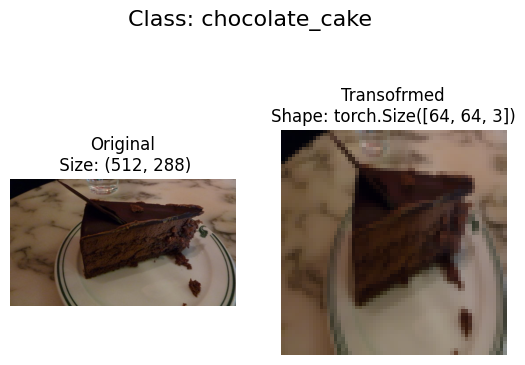

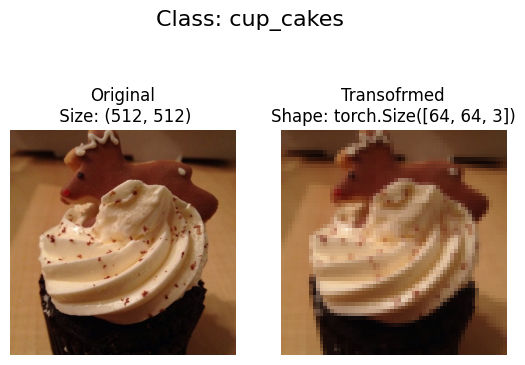

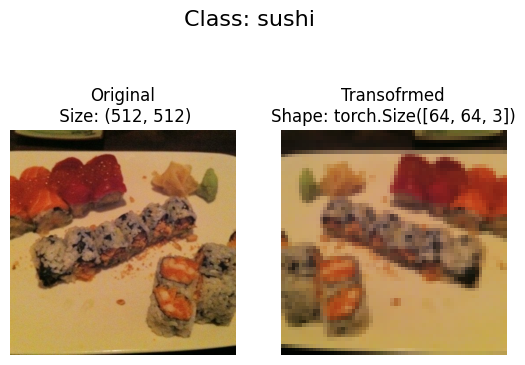

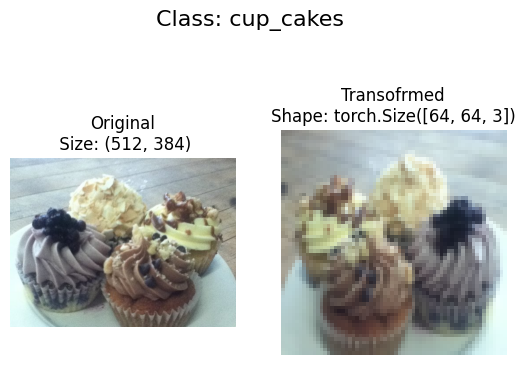

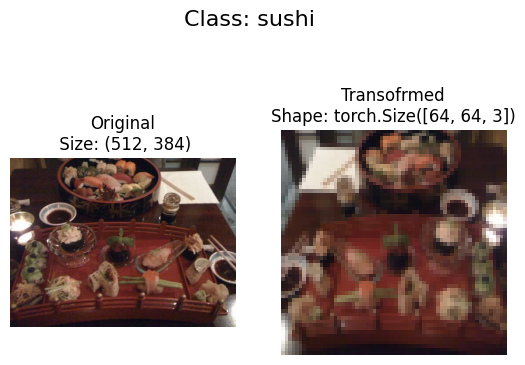

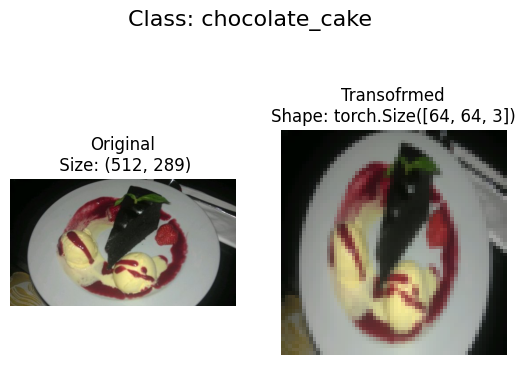

In [20]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=6,
                        seed=None)

Loading image data using image folder

In [21]:
train_dir

PosixPath('data/food_images/dataset/train')

In [22]:
test_dir

PosixPath('data/food_images/dataset/test')

In [23]:
data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

In [24]:
# Use ImageFolfer to create datasets

from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, # fetch images from inside folders
                                  transform=data_transform,
                                  target_transform=None) # don't want to transform the targets(lables) of our images

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [25]:
train_data

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: data/food_images/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [26]:
test_data

Dataset ImageFolder
    Number of datapoints: 300
    Root location: data/food_images/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [27]:
# get class names as list
class_names = train_data.classes
class_names

['chocolate_cake', 'cup_cakes', 'macarons', 'sushi']

In [28]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'chocolate_cake': 0, 'cup_cakes': 1, 'macarons': 2, 'sushi': 3}

In [29]:
# check the length of datasets
len(train_data), len(test_data)

(1000, 300)

In [30]:
img, label = train_data[500]

In [31]:
print(f"Image tensor:\n {img}")
print(f"Image shape:\n {img.shape}")
print(f"Image label:\n {label}")
print(f"Image datatype:\n {img.dtype}")
print(f"Label datatype:\n {type(label)}")

Image tensor:
 tensor([[[0.8471, 0.8510, 0.8549,  ..., 0.2863, 0.2627, 0.2549],
         [0.9294, 0.9294, 0.9294,  ..., 0.3961, 0.3451, 0.3216],
         [0.9333, 0.9333, 0.9294,  ..., 0.3804, 0.4078, 0.3922],
         ...,
         [0.4706, 0.4549, 0.4157,  ..., 0.3529, 0.3333, 0.3294],
         [0.3725, 0.3569, 0.3608,  ..., 0.3373, 0.3059, 0.2157],
         [0.3490, 0.3608, 0.3922,  ..., 0.2980, 0.1922, 0.1373]],

        [[0.8784, 0.8863, 0.8902,  ..., 0.3490, 0.3255, 0.3176],
         [0.9608, 0.9608, 0.9608,  ..., 0.4353, 0.3843, 0.3608],
         [0.9608, 0.9569, 0.9569,  ..., 0.4039, 0.4275, 0.4196],
         ...,
         [0.4627, 0.4431, 0.4000,  ..., 0.4157, 0.3961, 0.3922],
         [0.3686, 0.3490, 0.3490,  ..., 0.3922, 0.3647, 0.2627],
         [0.3451, 0.3569, 0.3843,  ..., 0.3490, 0.2392, 0.1725]],

        [[0.7059, 0.7020, 0.7059,  ..., 0.3569, 0.3216, 0.3137],
         [0.8157, 0.8078, 0.8039,  ..., 0.3961, 0.3686, 0.3490],
         [0.8353, 0.8314, 0.8275,  ..., 0.3

In [32]:
class_names[label]

'macarons'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permuted -> [height, width, color_channels]: torch.Size([64, 64, 3])


<function matplotlib.pyplot.show(close=None, block=None)>

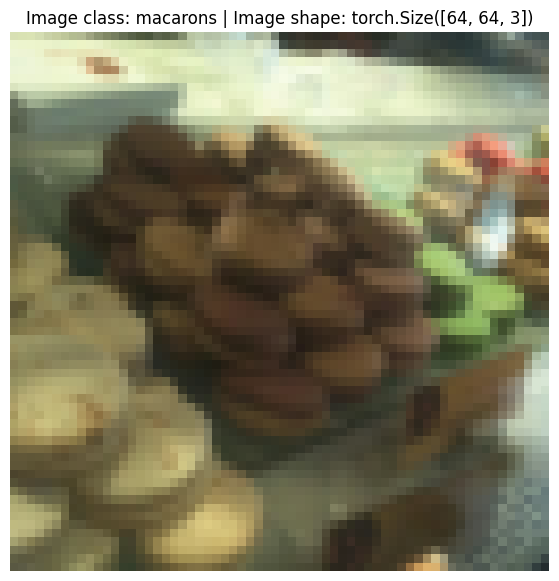

In [33]:
# rearrange the order of dimensions
img_permute = img.permute(1, 2, 0) # pytorch prefers color channels first and matplotlib prefers color channels at last so we need to permute them

# print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permuted -> [height, width, color_channels]: {img_permute.shape}")

# plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(f"Image class: {class_names[label]} | Image shape: {img_permute.shape}")
plt.show

In [34]:
# turn loaded images into DataLoaders

from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ce15ed400d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ce15ec60210>)

In [35]:
img_batch, label_batch = next(iter(train_dataloader))

print(f"Image shape: {img_batch.shape} -> [batch_size, color_channels, height, width]")
print(f"Label batch shape: {label_batch.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label batch shape: torch.Size([32])


In [36]:
label_batch

tensor([1, 0, 1, 3, 3, 3, 1, 1, 2, 3, 2, 1, 3, 1, 3, 0, 1, 2, 3, 0, 0, 2, 2, 3,
        2, 3, 1, 3, 2, 1, 0, 2])

In [37]:
img_batch, label_batch = next(iter(test_dataloader))

print(f"Image shape: {img_batch.shape} -> [batch_size, color_channels, height, width]")
print(f"Label batch shape: {label_batch.shape}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label batch shape: torch.Size([32])


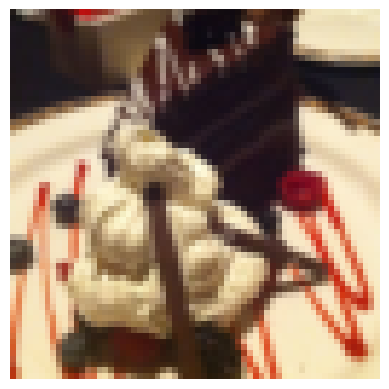

In [38]:
plt.imshow(img_batch[9].permute(1, 2, 0))
plt.axis("off")
plt.show()

## Building the Model

In [39]:
from typing import List, Tuple, Dict

In [40]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting n to 10 and removing shape display")

  # set the seed
  if seed:
    random.seed(seed)

  # get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # setup plot
  plt.figure(figsize=(16, 8))

  # loop through random indexes and plot with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_sample, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # adjust tensor dimensions for plotting
    targ_img_adjust = targ_sample.permute(1, 2, 0)

    # plot
    plt.subplot(1, n, i+1)
    plt.imshow(targ_img_adjust)
    plt.axis("off")

    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape: {targ_img_adjust.shape}"
    plt.title(title)

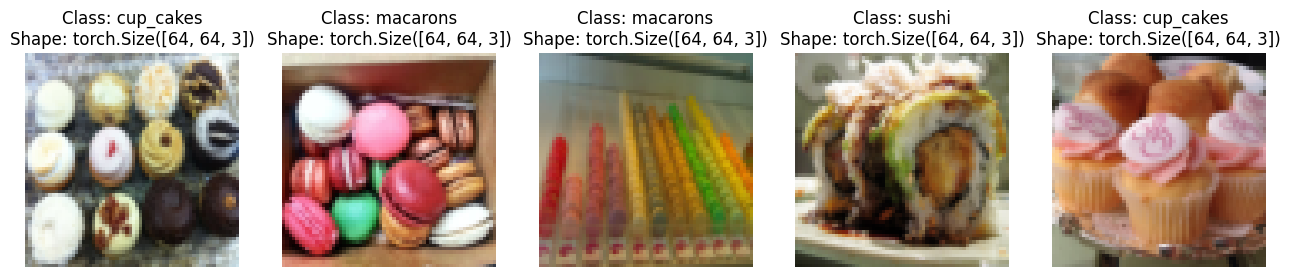

In [41]:
# call the function and plot random images
display_random_images(dataset=train_data,
                      classes=class_names,
                      n=5,
                      seed=None)

# Building TinyVGG Model

In [42]:
class TinyVGG(nn.Module):
  """
  Model architecture of TinyVGG from CNN Explainer
  """

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__() # calling all the methods and attributes from the parent class Module

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=(3, 3),
                  stride=(1, 1), # jump size -> how many steps to take
                  padding=0),
        nn.ReLU(), # learn complex non-linear relationships
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=(3, 3),
                  stride=(1, 1),
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2), # max pooling reduces overfitting and makes the processing faster
                     stride=(2, 2))
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2),
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=13*13*hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Shape after conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Shape after conv block 2: {x.shape}")
    x = self.classifier(x)
    # print(f"Shape after classification: {x.shape}")
    return x


In [43]:
# instantiating the model

torch.manual_seed(42)

model = TinyVGG(input_shape=3, # number of color channels in the image data
                hidden_units=10,
                output_shape=len(class_names)
                ).to(device)

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [44]:
# dummy forward pass by passing a single image

img_batch, label_batch = next(iter(train_dataloader))

img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [45]:
img_batch.device # need to transfer to gpu

device(type='cpu')

In [46]:
logits = model(img_batch.to(device))

Use `torchinfo` to get an idea of the shaepes going through the model

In [47]:
try:
  import torchinfo
except:
  !pip install -q torchinfo # q -> installs quitely
  import torchinfo

In [48]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 64, 64),)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## Creating a training and testing loop to train and evaluate the model

In [49]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  """
  This function will train a model on the dataloader and optimize
  the mdel's parameters to better represent out data.
  """

  # put model in train mode
  model.train()

  # setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # loop through the dataloader data batches
  for batch, (X, y) in enumerate(dataloader):
    # send data to the target device
    X, y = X.to(device), y.to(device)

    # forward pass
    y_pred = model(X)

    # calculate the loass
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    #optimizer zero gradient
    optimizer.zero_grad()

    # apply backpropagation algo
    loss.backward()

    # optimizer step ( gradient descent algorithm )
    optimizer.step()

    # calculate accuracy metric
    y_pred_class = torch.argmax(y_pred, dim=1) # Corrected: Get predicted class labels
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  # adjust metrics to get avg loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [50]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # put model in eval mode
  model.eval()

  # setup the test loss and accuracy values
  test_loss, test_acc = 0, 0

  # turn on inference mode
  with torch.inference_mode():

    # loop through dataloader batches
    for batch, (X, y) in enumerate(dataloader):

      # send data to the target device
      X, y = X.to(device), y.to(device)

      # forward pass
      test_pred_logits = model(X)

      # calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1) # Corrected: Get predicted class labels
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels)) # Corrected: Compare predicted labels with true labels

    # adjust metrics to get avg loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

### Creating `train()` to combine `train_step()` and `test_step()`

In [51]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # create empty results dict
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  # loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # update the results dict
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [52]:
# set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

model = TinyVGG(input_shape=3,
                hidden_units=40,
                output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3299 | Train acc: 0.3457 | Test loss: 1.3674 | Test acc: 0.3781
Epoch: 1 | Train loss: 1.2095 | Train acc: 0.4395 | Test loss: 1.2187 | Test acc: 0.4010
Epoch: 2 | Train loss: 1.1815 | Train acc: 0.4492 | Test loss: 1.1917 | Test acc: 0.4240
Epoch: 3 | Train loss: 1.1414 | Train acc: 0.5078 | Test loss: 1.1938 | Test acc: 0.4344
Epoch: 4 | Train loss: 1.0956 | Train acc: 0.5078 | Test loss: 1.1758 | Test acc: 0.4677
Epoch: 5 | Train loss: 1.0657 | Train acc: 0.5342 | Test loss: 1.1455 | Test acc: 0.4958
Epoch: 6 | Train loss: 1.0398 | Train acc: 0.5381 | Test loss: 1.1870 | Test acc: 0.4792
Epoch: 7 | Train loss: 1.0021 | Train acc: 0.5859 | Test loss: 1.2007 | Test acc: 0.4833
Epoch: 8 | Train loss: 1.0207 | Train acc: 0.5781 | Test loss: 1.2117 | Test acc: 0.4573
Epoch: 9 | Train loss: 0.9760 | Train acc: 0.5869 | Test loss: 1.2178 | Test acc: 0.4917
Total training time: 144.350 seconds


In [53]:
model_results

{'train_loss': [1.3299295641481876,
  1.2094920761883259,
  1.1815062183886766,
  1.1413793601095676,
  1.09557986818254,
  1.0657263230532408,
  1.039756152778864,
  1.0020708944648504,
  1.020714771002531,
  0.9760276302695274],
 'train_acc': [0.345703125,
  0.439453125,
  0.44921875,
  0.5078125,
  0.5078125,
  0.5341796875,
  0.5380859375,
  0.5859375,
  0.578125,
  0.5869140625],
 'test_loss': [1.3674024641513824,
  1.218736505508423,
  1.1916667461395263,
  1.1937941491603852,
  1.1757953464984894,
  1.1455354750156403,
  1.1869516968727112,
  1.2006853759288787,
  1.2117163598537446,
  1.21775181889534],
 'test_acc': [0.378125,
  0.4010416666666667,
  0.4239583333333333,
  0.434375,
  0.4677083333333333,
  0.4958333333333333,
  0.4791666666666667,
  0.4833333333333333,
  0.4572916666666667,
  0.4916666666666667]}

In [54]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """
  Plots training curves of results.
  """

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

  plt.show()

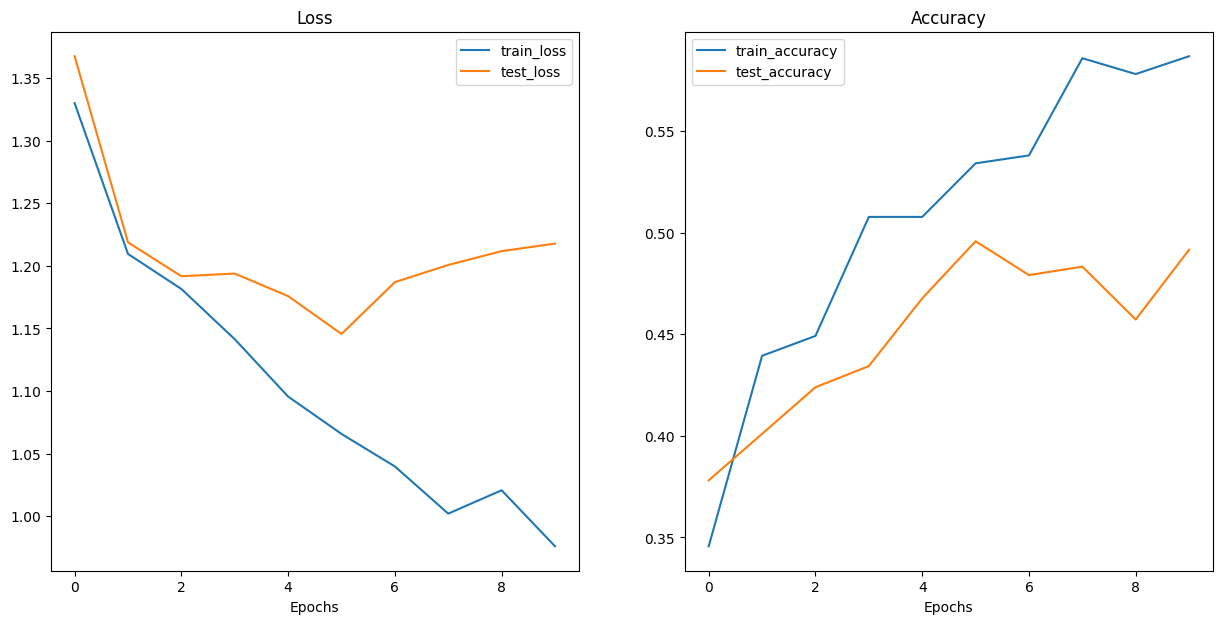

In [55]:
plot_loss_curves(model_results)

In [60]:
from PIL import Image
import requests
from io import BytesIO

def predict_class(image_path: str):
  # Check if the input is a URL
  if image_path.startswith('http'):
    response = requests.get(image_path)
    image = Image.open(response.content)
  else:
    image = Image.open(image_path)

  transformed_img = data_transform(image).unsqueeze(0).to(device) # Move image to device

  with torch.no_grad():
    output = model(transformed_img)

  print(f"Predicted class: {class_names[output.argmax()]}")

In [67]:
image_path = "/content/images (2).jpeg"

predict_class(image_path)

Predicted class: cup_cakes
